Please keep the input file "kidneyChronic.csv" in the same folder as .ipynb file

Importing the required libraries

In [ ]:
import pandas as pd
import os
import plotly.express as px
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report,accuracy_score
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
# defining a function that helps us in plotting the ROC curve 
def auc_scorer(clf, X, y, model): # Helper function to plot the ROC curve
    if model=='RF':
        fpr, tpr, _ = roc_curve(y, clf.predict_proba(X)[:,1])
    elif model=='SVM':
        fpr, tpr, _ = roc_curve(y, clf.decision_function(X))
    roc_auc = auc(fpr, tpr)

    plt.figure()    # Plot the ROC curve
    plt.plot(fpr, tpr, label='ROC curve from '+model+' model (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    return fpr,tpr,roc_auc

In [ ]:
# using pandas we are reading the kidneyChronic.csv from the directory and storing that as dataframe df
df=pd.read_csv("kidneyChronic.csv")

In [ ]:
# Cleaning the dataset , here we replaced the ? in the data with None
df=df.replace({"?":None})

In [ ]:
# printing the basic info about the data frame and understanding the number of null values in each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   age     391 non-null    object
 1   bp      388 non-null    object
 2   sg      353 non-null    object
 3   al      354 non-null    object
 4   su      351 non-null    object
 5   rbc     248 non-null    object
 6   pc      335 non-null    object
 7   pcc     396 non-null    object
 8   ba      396 non-null    object
 9   bgr     356 non-null    object
 10  bu      381 non-null    object
 11  sc      383 non-null    object
 12  sod     313 non-null    object
 13  pot     312 non-null    object
 14  hemo    348 non-null    object
 15  pcv     330 non-null    object
 16  wbcc    295 non-null    object
 17  rbcc    270 non-null    object
 18  htn     398 non-null    object
 19  dm      398 non-null    object
 20  cad     398 non-null    object
 21  appet   399 non-null    object
 22  pe      399 non-null    ob

In [ ]:
# getting a basic idea about the columns in the dataset
df.describe()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
count,391,388,353,354,351,248,335,396,396,356,381,383,313,312,348,330,295,270,398,398,398,399,399,399,400
unique,76,10,5,6,6,2,2,2,2,146,118,84,34,40,115,44,92,46,2,5,3,2,2,2,2
top,60,80,1.02,0,0,normal,normal,notpresent,notpresent,99,46,1.2,135,3.5,15,52,9800,5.2,no,no,no,good,no,no,ckd
freq,19,116,106,199,290,201,259,354,374,10,15,40,40,30,16,21,11,18,251,258,362,317,323,339,250


In [ ]:
#Replacing the column names in the df to get more intuitive names
column_dict={"age":"age","bp":"blood pressure","sg":"specific gravity","al":"albumin","su":"sugar","rbc":"red blood cells","pc":"pus cell","pcc":"pus cell clumps","ba":"bacteria","bgr":"blood glucose random","bu":"blood urea","sc":"serum creatinine","sod":"sodium","pot":"potassium","hemo":"hemoglobin","pcv":"packed cell volume","wc":"white blood cell count","rc":"red blood cell count","htn":"hypertension","dm":"diabetes mellitus","cad":"coronary artery disease","appet":"appetite","pe":"pedal edema","ane":"anemia","class":"class"}
df.rename(columns=column_dict,inplace=True)
df.head(1)

,age,blood pressure,specific gravity,albumin,sugar,red blood cells,pus cell,pus cell clumps,bacteria,blood glucose random,blood urea,serum creatinine,sodium,potassium,hemoglobin,packed cell volume,wbcc,rbcc,hypertension,diabetes mellitus,coronary artery disease,appetite,pedal edema,anemia,class
0,48,80,1.02,1,0,None,normal,notpresent,notpresent,121,36,1.2,None,None,15.4,44,7800,5.2,yes,yes,no,good,no,no,ckd


In [ ]:
# Defining numeric colmns in the data
numeric_columns=['age', 'blood pressure','blood glucose random', 'blood urea', 'serum creatinine', 'sodium','potassium', 'hemoglobin', 'packed cell volume', 'wbcc', 'rbcc']

In [ ]:
# from plotly.subplots import make_subplots
# import plotly.graph_objects as go
# fig=make_subplots(4, cols=3, shared_yaxes=False,subplot_titles=numeric_columns)
# for i,col in enumerate(numeric_columns):
#     col1=[1,2,3,1,2,3,1,2,3,1,2]
#     row1=[1,1,1,2,2,2,3,3,3,4,4,4]
#     fig.add_trace(go.Box(x=df["class"],y=df[col],name=col
#                      ),
#     row=row1[i], #index for the subplot, i+1 because plotly starts with 1
#                       col=col1[i])
#     fig.update_layout(autosize=False,
#     width=1500,
#     height=5000,showlegend=False)
# fig.show()


In [ ]:
# Plotting box plots for numeric columns in the data
for col in numeric_columns:
  fig = px.box(df, x="class", y=col,title='Boxplot for {}'.format(col))
  fig.update_layout(autosize=False,
    width=500,
    height=500,)
  fig.show()


In [ ]:
# Defining and storing the categorical variables in the dataset into a list
cat_variables=['red blood cells', 'pus cell', 'albumin', 'sugar', 'specific gravity', 'pus cell clumps', 'bacteria','hypertension', 'diabetes mellitus', 'coronary artery disease',
       'appetite', 'pedal edema', 'anemia','class']


In [ ]:
# checking the unique values in the categorical columns in the dataset
for col in cat_variables:
  print(col,"- unique values: ",df[col].unique())

red blood cells - unique values:  [None 'normal' 'abnormal']
pus cell - unique values:  ['normal' 'abnormal' None]
albumin - unique values:  ['1' '4' '2' '3' '0' None '5']
sugar - unique values:  ['0' '3' '4' '1' None '2' '5']
specific gravity - unique values:  ['1.02' '1.01' '1.005' '1.015' None '1.025']
pus cell clumps - unique values:  ['notpresent' 'present' None]
bacteria - unique values:  ['notpresent' 'present' None]
hypertension - unique values:  ['yes' 'no' None]
diabetes mellitus - unique values:  ['yes' 'no' nan]
coronary artery disease - unique values:  ['no' 'yes' nan]
appetite - unique values:  ['good' 'poor' None]
pedal edema - unique values:  ['no' 'yes' None]
anemia - unique values:  ['no' 'yes' None]
class - unique values:  ['ckd' 'notckd']


In [ ]:
# mapping values in the columns for standardising the values
variables={'yes':'yes', 'no':'no', '\tno':'no','\tyes':'yes'}
df['diabetes mellitus']=df['diabetes mellitus'].map(variables)
df['coronary artery disease']=df['coronary artery disease'].map(variables)

In [ ]:
# plotting a histogram for categorical columns in the dataset 
import matplotlib.pyplot as plt

df1 = df[cat_variables]
for i, col in enumerate(df1.columns):
    fig = px.histogram(df1,x=col, color='class',title='Histogram of {}'.format(col)) 
    fig.update_layout(autosize=False,
    width=500,
    height=500,)
    fig.show()



    

In [ ]:
# splitting the dataset into two based on the class they belong to
print(df["class"].unique())
df_ckd=df[df["class"]=="ckd"]
df_notckd=df[df["class"]=="notckd"]
print(df_ckd.shape,df_notckd.shape)

['ckd' 'notckd']
(250, 25) (150, 25)


In [ ]:
# % null values in each column in the two dataframes seperately
print("For CKD\n",df_ckd.isna().sum()*100/df_ckd.shape[0],"\nFor not_CKD\n",df_notckd.isna().sum()*100/df_notckd.shape[0])


For CKD
 age                         3.2
blood pressure              4.0
specific gravity           16.8
albumin                    16.4
sugar                      17.6
red blood cells            57.2
pus cell                   22.4
pus cell clumps             0.0
bacteria                    0.0
blood glucose random       15.2
blood urea                  5.2
serum creatinine            4.8
sodium                     32.8
potassium                  33.2
hemoglobin                 18.4
packed cell volume         26.4
wbcc                       39.2
rbcc                       49.2
hypertension                0.0
diabetes mellitus           0.4
coronary artery disease     0.0
appetite                    0.0
pedal edema                 0.0
anemia                      0.0
class                       0.0
dtype: float64 
For not_CKD
 age                        0.666667
blood pressure             1.333333
specific gravity           3.333333
albumin                    3.333333
sugar             

In [ ]:
# filling the na values in the numerics columns with median values of the columns

for col in numeric_columns:
  df_ckd[col] = df_ckd[col].apply(pd.to_numeric, errors='coerce')
  df_ckd[col].fillna(df_ckd[col].median(), inplace=True)
# filling the na values in the categorical columns with mode values of the columns
for col in cat_variables:
    df_ckd[col].fillna(df_ckd[col].mode()[0], inplace=True)

In [ ]:
# checking the number of null values
df_ckd.isnull().sum()

age                        0
blood pressure             0
specific gravity           0
albumin                    0
sugar                      0
red blood cells            0
pus cell                   0
pus cell clumps            0
bacteria                   0
blood glucose random       0
blood urea                 0
serum creatinine           0
sodium                     0
potassium                  0
hemoglobin                 0
packed cell volume         0
wbcc                       0
rbcc                       0
hypertension               0
diabetes mellitus          0
coronary artery disease    0
appetite                   0
pedal edema                0
anemia                     0
class                      0
dtype: int64

In [ ]:
# filling the na values in the numerics columns with median values of the columns
for col in numeric_columns:
  df_notckd[col] = df_notckd[col].apply(pd.to_numeric, errors='coerce')
  df_notckd[col].fillna(df_notckd[col].median(), inplace=True)
# filling the na values in the categorical columns with mode values of the columns
for col in cat_variables:
    df_notckd[col].fillna(df_notckd[col].mode()[0], inplace=True)

In [ ]:
# checking the number of null values
df_notckd.isnull().sum()

age                        0
blood pressure             0
specific gravity           0
albumin                    0
sugar                      0
red blood cells            0
pus cell                   0
pus cell clumps            0
bacteria                   0
blood glucose random       0
blood urea                 0
serum creatinine           0
sodium                     0
potassium                  0
hemoglobin                 0
packed cell volume         0
wbcc                       0
rbcc                       0
hypertension               0
diabetes mellitus          0
coronary artery disease    0
appetite                   0
pedal edema                0
anemia                     0
class                      0
dtype: int64

In [ ]:
# after imputing the null values we stack the dataframes back to the original shape 
ckd_df=pd.concat([df_ckd,df_notckd])

In [ ]:
# checking the number of rows and columns in the final dataset
ckd_df.shape

(400, 25)

In [ ]:
# mapping the column names to corrsponding values in them so that the values can be encoded sequentially
nor=["red blood cells",'pus cell']
not_p=['pus cell clumps','bacteria']
yes_no=['hypertension', 	'diabetes mellitus', 	'coronary artery disease', 		'pedal edema', 	'anemia']


In [ ]:
# encoding the values in the columns to zeros or ones
ckd_df['appetite']=ckd_df['appetite'].replace(to_replace={'good':1,'poor':0})
ckd_df['class']=ckd_df['class'].replace(to_replace={'ckd':1,'notckd':0})
for col in nor:
    ckd_df[col]=ckd_df[col].replace(to_replace={'abnormal':1,'normal':0})

for col in not_p:
    ckd_df[col]=ckd_df[col].replace(to_replace={'present':1,'notpresent':0})

for col in yes_no:
    ckd_df[col]=ckd_df[col].replace(to_replace={'yes':1,'no':0})


In [ ]:
# checking the unique values in the columns of categorical data in the dataset
for col in cat_variables:
  print(col,"- unique values: ",ckd_df[col].unique())

red blood cells - unique values:  [0 1]
pus cell - unique values:  [0 1]
albumin - unique values:  ['1' '4' '2' '3' '0' '5']
sugar - unique values:  ['0' '3' '4' '1' '2' '5']
specific gravity - unique values:  ['1.02' '1.01' '1.005' '1.015' '1.025']
pus cell clumps - unique values:  [0 1]
bacteria - unique values:  [0 1]
hypertension - unique values:  [1 0]
diabetes mellitus - unique values:  [1 0]
coronary artery disease - unique values:  [0 1]
appetite - unique values:  [1 0]
pedal edema - unique values:  [0 1]
anemia - unique values:  [0 1]
coronary artery disease - unique values:  [0 1]


In [ ]:
# checking the dtypes for the columns in the dataset
ckd_df.dtypes

age                        float64
blood pressure             float64
specific gravity            object
albumin                     object
sugar                       object
red blood cells              int64
pus cell                     int64
pus cell clumps              int64
bacteria                     int64
blood glucose random       float64
blood urea                 float64
serum creatinine           float64
sodium                     float64
potassium                  float64
hemoglobin                 float64
packed cell volume         float64
wbcc                       float64
rbcc                       float64
hypertension                 int64
diabetes mellitus            int64
coronary artery disease      int64
appetite                     int64
pedal edema                  int64
anemia                       int64
class                        int64
dtype: object

In [ ]:
# scaling the numerical data in the dataset for removing the bias in the data

from sklearn import preprocessing

# x = num_cols.values #returns a numpy array
# min_max_scaler = preprocessing.MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(x)
# num_cols = pd.DataFrame(x_scaled)
scaler=preprocessing.MinMaxScaler()
def scale_data(data, columns, scaler):
    for col in columns:
        data[col] = scaler.fit_transform(data[col].values.reshape(-1, 1))
    return data

ckd_df=scale_data(ckd_df,numeric_columns,scaler)

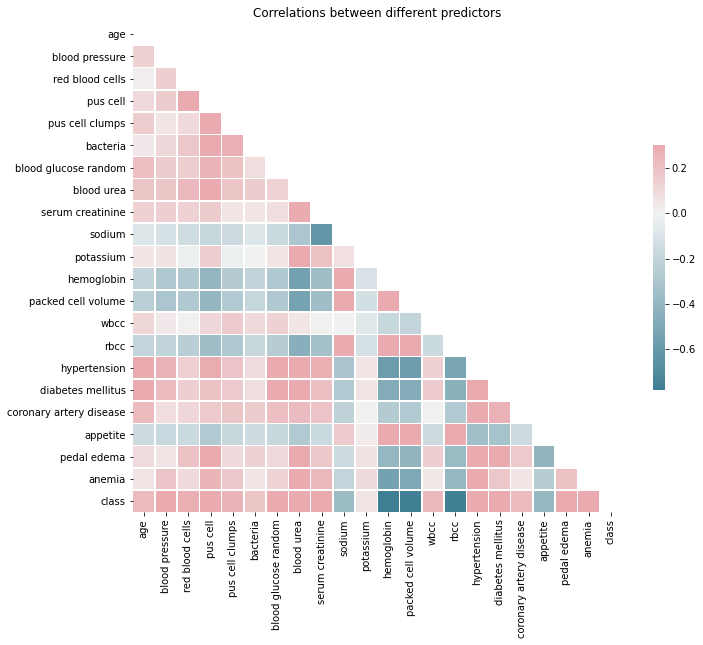

In [ ]:
# plotting a correlation matrix on the dataset 

corr_df = ckd_df.corr()


# Generate a mask for the upper triangle
mask = np.zeros_like(corr_df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_df, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlations between different predictors')
plt.show()



In [ ]:
# splitting the dataset into training and testing data 
X_train, X_test, y_train, y_test = train_test_split(ckd_df.iloc[:,:-1], ckd_df['class'], 
                                                    test_size = 0.33, random_state=44,
                                                   stratify= ckd_df['class'] )

In [ ]:
# checking the size of the test and train data
print(X_train.shape)
print(X_test.shape)


(268, 24)
(132, 24)


Detailed classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        82

    accuracy                           1.00       132
   macro avg       1.00      1.00      1.00       132
weighted avg       1.00      1.00      1.00       132

Confusion Matrix:
[[50  0]
 [ 0 82]]


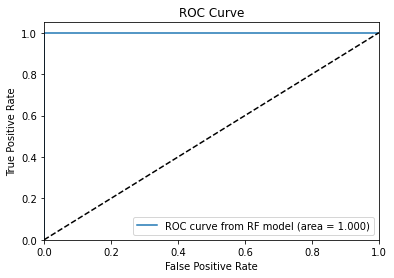

Best parameters:
{'class_weight': {0: 0.33, 1: 0.67}, 'max_depth': 4, 'n_estimators': 16, 'random_state': 42}


In [ ]:
# here we use a grid search method for finding out the best parameters for the random forest classifier to get the maximum accuracy on the datset
tuned_parameters = [{'n_estimators':[7,8,9,10,11,12,13,14,15,16],'max_depth':[2,3,4,5,6,None],
                     'class_weight':[None,{0: 0.33,1:0.67},'balanced'],'random_state':[42]}]
clf = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=10,scoring='f1')
clf.fit(X_train, y_train)

print("Detailed classification report:")
y_true, lr_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, lr_pred))

confusion = confusion_matrix(y_test, lr_pred)
print('Confusion Matrix:')
print(confusion)

# Determine the false positive and true positive rates
fpr,tpr,roc_auc = auc_scorer(clf, X_test, y_test, 'RF')

print('Best parameters:')
print(clf.best_params_)
clf_best = clf.best_estimator_

Text(0.5, 1.0, 'Feature Importance')

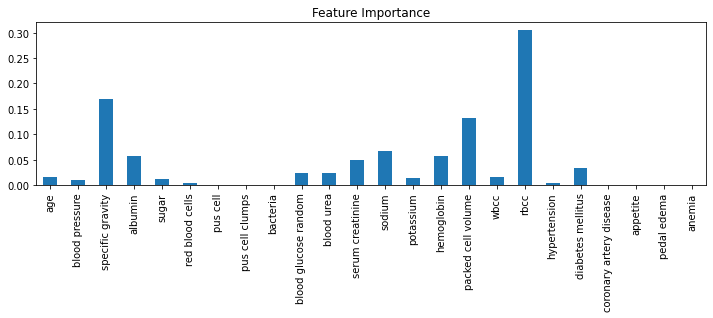

In [ ]:
# from the model that we created for the data we are plotting the feature importance of each column
plt.figure(figsize=(12,3))
features = X_test.columns.values.tolist()
importance = clf_best.feature_importances_.tolist()
feature_series = pd.Series(data=importance,index=features)
feature_series.plot.bar()
plt.title('Feature Importance')

In [ ]:
# capturing the column swith importance greater than 0 for using these columns in other models
list_to_fill = X_test.columns[feature_series>0]
print(list_to_fill)

Index(['age', 'blood pressure', 'specific gravity', 'albumin', 'sugar',
       'red blood cells', 'blood glucose random', 'blood urea',
       'serum creatinine', 'sodium', 'potassium', 'hemoglobin',
       'packed cell volume', 'wbcc', 'rbcc', 'hypertension',
       'diabetes mellitus'],
      dtype='object')


In [ ]:
# creating the test and and train data with only the important columns in the data
X_test2=X_test[list_to_fill]
X_train2=X_train[list_to_fill]

              precision    recall  f1-score   support

           0       0.91      1.00      0.95        50
           1       1.00      0.94      0.97        82

    accuracy                           0.96       132
   macro avg       0.95      0.97      0.96       132
weighted avg       0.97      0.96      0.96       132

Confusion Matrix:
[[50  0]
 [ 5 77]]


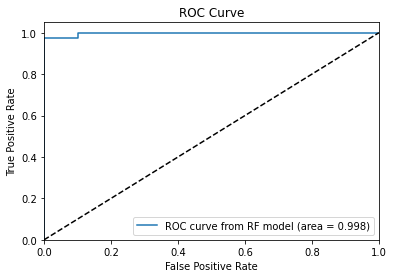

In [ ]:
#creating models and measuring accuracy
#Logistic Regression
from sklearn.linear_model import LogisticRegression
LogReg=LogisticRegression()
LogRegModel=LogReg.fit(X_train2,y_train)
# LogRegModel=LogReg.fit(X,y)
LogRegModel.score(X_train2,y_train)
# LogRegModel.score(X,y)
#Accuracy calculated using Confusion Matrix
LogRegPredict=LogRegModel.predict(X_test2)
# pd.crosstab(df['class'],LogRegPredict)
pd.crosstab(y_test,LogRegPredict)
print(classification_report(y_test, LogRegPredict))
confusion = confusion_matrix(y_test, LogRegPredict)
print('Confusion Matrix:')
print(confusion)
fpr,tpr,roc_auc = auc_scorer(LogRegModel, X_test2, y_test, 'RF')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        82

    accuracy                           1.00       132
   macro avg       1.00      1.00      1.00       132
weighted avg       1.00      1.00      1.00       132

Confusion Matrix:
[[50  0]
 [ 0 82]]


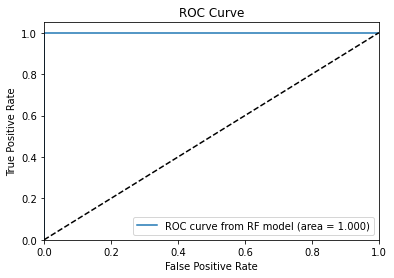

In [ ]:
#DECISION TREE CLASSIFIER
from sklearn.tree import DecisionTreeClassifier
DecTree=DecisionTreeClassifier()
DecTreemodel=DecTree.fit(X_train2,y_train)
DecTreemodel.score(X_train2,y_train)
DecTreepredict=DecTreemodel.predict(X_test2)
pd.crosstab(y_test,DecTreepredict)

print(classification_report(y_test, DecTreepredict))
confusion = confusion_matrix(y_test, DecTreepredict)
print('Confusion Matrix:')
print(confusion)
fpr,tpr,roc_auc = auc_scorer(DecTreemodel, X_test2, y_test, 'RF')